In [1]:
# All the "relevant" input files
# I have "relevant" in quotes because I don't remember
# how I picked these files. So you should probably redownload the
# CHILDES treebank yourself and familiarize yourself with it
# to be sure this is right

folder_name = "childes-treebank-parse-trees/"

fi1 = open(folder_name + "brown-adam.parsed", "r")
fi2 = open(folder_name + "brown-eve+animacy+theta.parsed", "r")
fi3 = open(folder_name + "brown-sarah.parsed", "r")
fi4 = open(folder_name + "soderstrom.parsed", "r")
fi5 = open(folder_name + "suppes.parsed", "r")
fi6 = open(folder_name + "valian+animacy+theta.parsed", "r")

trees = []
tree = ""

# Iterate over all the files
for fi in [fi1, fi2, fi3, fi4, fi5, fi6]:
    # Iterate over the lines in this file to add trees to the list of trees
    for line in fi:
        # If you have completed a tree, add it to the list of trees
        if line.strip() == "":
            if tree.strip() != "" and tree.count(")") == tree.count("(") and tree.count("ROOT") == 1:
                trees.append(tree)
            #print(tree)
            tree = ""
            #break
        else:
            tree += line.strip()


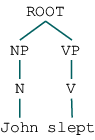

In [2]:
# NLTK tools for processing trees. You will need to have NLTK installed 
# to import this.
from nltk.tree import *

# Example of the NLTK tools
Tree.fromstring("(ROOT (NP (N John)) (VP (V slept)))")

In [3]:
# Creating an output file with all sentences (not trees,
# just sentences) from the input files
fo = open("childes.allsents", "w")
treesPrime = []

# Loop over the trees
for tree in trees:
    
    # I think this "if" condition is to check if the tree is complete
    # in some way? 
    if tree[-1] == ")" and tree[0] == "(":
        # Get the list of words in the tree, i.e. its leaves
        words = (Tree.fromstring(tree)).leaves()
        
        # Now we filter the words, because the treebank contains some
        # null elements we want to ignore
        wordsFiltered = []
        for word in words:
            if "*" not in word:
                wordsFiltered.append(word)
        fo.write(" ".join(wordsFiltered) + "\n")
        
        # I don't remeber what this is doing
        if "\\" not in tree:
            treesPrime.append(tree)

In [4]:
# The next few cells are just me playing around with NLTK tree 
# functions and getting a feel of how the trees are structured 
# in the treebank
treesPrime[0]

'(ROOT(FRAG(NP(JJ big)(NN drum))(. ?)))'

In [5]:
trees[1735]

"(ROOT(SQ(NP(PRP you))(VP(AUX 're)(VP(VBG turning)(NP(PRP it))(PRT(RP over))))(. ?)))"

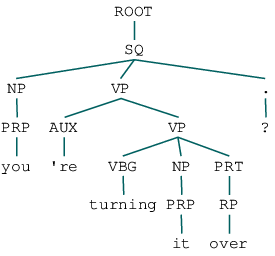

In [6]:
exp = Tree.fromstring(trees[1735])
exp

In [7]:
labels = [child.label() for child in exp]
labels


['SQ']

In [8]:
exp.label() # Gives the label of the tree's root

'ROOT'

In [9]:
for child in exp[0]:
    print(child.label())

labels = [child.label() for child in exp[0]]
labels

NP
VP
.


['NP', 'VP', '.']

In [10]:
# Method to de-question-ify a question; that is, to turn a 
# question into a declarative. I'm afraid I don't remember
# exactly how this is working.
def deQuest(tree):
    
    result = []
    
    # Check for a couple of cases that don't work (I forget
    # exactly why they don't work)
    good = 1
    if len(tree[0]) != 2:
        good = 0
    elif tree[0][0].label() != "VP" and tree[0][1].label() != ".":
        good = 0
        
    # This for loop is where the heavy lifting happens.
    # It is based on the NLTK tree methods, building on some
    # analysis of how the relevant trees are structured in the treebank.
    # But to understand what is going on you would probably need to work through 
    # some examples. The key thing is this:
    # - in the input tree, the auxiliary is at the top of the tree
    # - in the output, we want the auxiliary to be returned to 
    #   its rightful place within the sentence
    # One case to watch out for: Contractions are represented as 2 words,
    # and you have to move both words. e.g., "do n't you think so ?" -> "you do n't think so ."
    for child in tree[0]:
        if child.label() == "VP":
            toAdd = []
            added = 0
            if "NP" in child[0].label():
                good = 0
            for kid in child:
                if "NP" in kid.label() and not added:
                    result += kid.leaves()
                    result += toAdd
                    added = 1
                elif not added:
                    toAdd += kid.leaves()
                else:
                    result += kid.leaves()
                
        else:
            result += child.leaves()
            
    if good: 
        return result[:-1] + ["."]
    else:
        return "WRONG"
    

In [11]:
# In this block, we generate input-output pairs from all
# of our sentences. If the sentence is a yes-no question,
# the input is the de-questionified version of the question,
# while the output is the question. Otherwise, the input and
# the output are both the sentence. 
# For our current purposes, I think we only need the yes-no
# questions. So you can ignore the sentences that are not
# yes-no questions.
counter = 0
countQ = 0
total = 0
countIntj = 0
countFrag = 0
#foBoth = open("done-childes.decl-quest" + the_filename + ".txt", "w")
foBoth = open("childes.decl-quest.txt", "w")


# I'm sure that all the "if"s here are checking for
# various edge cases, but I forget which edge cases they all are
for tree in treesPrime:
    okay = True
    if tree.count("(") > 2:
        total += 1
        newTree = Tree.fromstring(tree) 
        for child in newTree[0]:
            if isinstance(child, str):
                okay = False
        if okay:
            
            if total % 10000 == 0:
                print(total)
            labels = [child.label() for child in newTree[0]]
            
            # So I think that this is the condition that you can use to check if a 
            # tree is a yes-no question
            if len(newTree) == 1 and newTree[0].label() == "SQ":
                countQ += 1
                treeEdit = []
                
                # This is to get rid of the unpronounced words that are in some
                # of the trees
                for node in newTree.leaves():
                    if "*" not in node:
                        treeEdit.append(node)
                        
                
                # Here we generate the declarative from the question.
                declForm = []
                if deQuest(newTree) != "WRONG":
                    if treeEdit[0] in ["do", "does", "did", "is", "was", "are", "were", "am", "has", "have", "had", 
                                           "can", "may", "might", "must", "will", "wo", "shall", "would", "could", "should"]:
                        #print(treeEdit)
                        for node in deQuest(newTree):
                            if "*" not in node:
                                declForm.append(node)
                        foBoth.write(" ".join(declForm) + "\t" + " ".join(treeEdit) + "\n")
                

print(counter, countQ, countIntj, countFrag, total)

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
0 18779 0 0 173739
